<a href="https://colab.research.google.com/github/ioscbasotcstw/100DaysOfTriton/blob/main/100DaysOfTriton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install triton

In [2]:
import torch

import os
os.environ["TRITON_DEBUG"] = "1"
import triton
print("TRITON_DEBUG set:", os.environ.get("TRITON_DEBUG"))
import triton.language as tl
print(triton.__version__)

DEVICE = "cuda"

TRITON_DEBUG set: 1
3.1.0


# Day 1

In [13]:
@triton.jit
def _add_kernel(
    x_ptr,
    y_ptr,
    output_ptr,
    num_el,
    BLOCK_SIZE: tl.constexpr
    ):

  pid = tl.program_id(axis=0)

  block_start = pid * BLOCK_SIZE

  offs = block_start + tl.arange(0, BLOCK_SIZE)

  mask = offs < num_el

  x = tl.load(x_ptr + offs, mask=mask)
  y = tl.load(y_ptr + offs, mask=mask)

  output = x + y

  tl.store(output_ptr + offs, output, mask=mask)

In [14]:
def add(x: torch.Tensor, y: torch.Tensor):

  output = torch.empty_like(x)

  assert x.device == torch.device("cuda:0") and y.device == torch.device("cuda:0") and output.device == torch.device("cuda:0"), f"Tensors have wrong device expected cuda, but got x: {x.device}, y: {y.device} and output: {output.device}"

  num_el = output.numel()

  grid = lambda meta: (triton.cdiv(num_el, meta["BLOCK_SIZE"]),)

  _add_kernel[grid](
      x_ptr      = x,
      y_ptr      = y,
      output_ptr = output,
      num_el     = num_el,
      BLOCK_SIZE = 1024
  )

  return output

In [15]:
torch.manual_seed(0)
size = 1_000_000
x = torch.rand(size, device="cuda")
y = torch.rand(size, device="cuda")
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([1.0580, 0.6002, 0.3803,  ..., 0.4953, 0.8494, 1.0207], device='cuda:0')
tensor([1.0580, 0.6002, 0.3803,  ..., 0.4953, 0.8494, 1.0207], device='cuda:0')
The maximum difference between torch and triton is 0.0


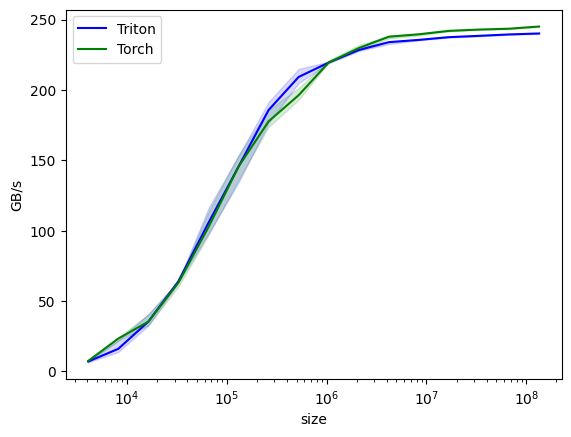

vector-add-performance:
           size      Triton       Torch
0        4096.0    6.981818    7.384615
1        8192.0   15.999999   23.272727
2       16384.0   35.310345   35.310345
3       32768.0   63.999998   63.015384
4       65536.0  105.476395  102.400003
5      131072.0  145.420113  145.420113
6      262144.0  185.654385  177.604328
7      524288.0  209.157447  196.215579
8     1048576.0  219.428568  219.428568
9     2097152.0  228.282153  229.682243
10    4194304.0  233.917907  237.772341
11    8388608.0  235.511559  239.510281
12   16777216.0  237.458234  241.941858
13   33554432.0  238.403038  242.850077
14   67108864.0  239.392948  243.470333
15  134217728.0  240.079781  245.013480


In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device="cuda", dtype=torch.float32)
    y = torch.rand(size, device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(print_data=True, show_plots=True)

# Day 2

In [ ]:
@triton.jit
def _relu(
    x_ptr,
    output_ptr,
    num_el,
    BLOCK_SIZE: tl.constexpr
):

  pid = tl.program_id(axis=0)

  block_start = pid * BLOCK_SIZE

  offs = block_start + tl.arange(0, BLOCK_SIZE)

  mask = offs < num_el

  x = tl.load(x_ptr + offs, mask=mask)

  output = tl.maximum(x, 0.0)

  tl.store(output_ptr + offs, output, mask=mask)

In [ ]:
def relu(x: torch.Tensor):
  output = torch.empty_like(x)

  assert x.device == torch.device("cuda:0") and output.device == torch.device("cuda:0"), f"Tensors have wrong device expected cuda, but got x: {x.device} and output: {output.device}"

  num_el = output.numel()

  grid = lambda meta: (triton.cdiv(num_el, meta["BLOCK_SIZE"]),)

  _relu[grid](
      x_ptr      = x,
      output_ptr = output,
      num_el     = num_el,
      BLOCK_SIZE = 1024
  )

  return output

In [ ]:
torch.manual_seed(0)
size = 100_000
x = torch.rand(size, device="cuda")
output_torch = torch.relu(x)
output_triton = relu(x)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([0.3990, 0.5167, 0.0249,  ..., 0.2813, 0.8104, 0.6009], device='cuda:0')
tensor([0.3990, 0.5167, 0.0249,  ..., 0.2813, 0.8104, 0.6009], device='cuda:0')
The maximum difference between torch and triton is 0.0


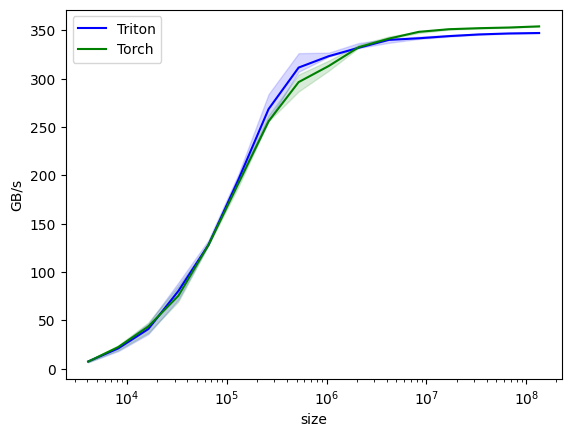

relu-performance:
           size      Triton       Torch
0        4096.0    7.349282    7.245283
1        8192.0   20.897959   22.260869
2       16384.0   40.959998   43.574469
3       32768.0   80.313725   75.386501
4       65536.0  127.999995  127.999995
5      131072.0  195.824709  192.000000
6      262144.0  268.590169  255.999991
7      524288.0  311.581630  296.542993
8     1048576.0  323.368435  313.194740
9     2097152.0  332.108094  332.670041
10    4194304.0  340.225824  341.518617
11    8388608.0  341.908362  348.595753
12   16777216.0  344.133903  351.281743
13   33554432.0  345.879179  352.344086
14   67108864.0  346.899500  353.045990
15  134217728.0  347.363956  354.231202


In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='relu-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.relu(x), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: relu(x), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(print_data=True, show_plots=True)

# Day 3

In [ ]:
@triton.jit
def _relu_fwd(
    x_ptr,
    out_ptr,
    num_el: tl.constexpr,
    BLOCK_SIZE: tl.constexpr
):
  pid = tl.program_id(axis=0)
  start_block = pid * BLOCK_SIZE
  offs = start_block + tl.arange(0, BLOCK_SIZE)

  mask = offs < num_el
  x = tl.load(x_ptr + offs, mask=mask)
  output = tl.maximum(x, 0.0)
  tl.store(out_ptr + offs, output, mask=mask)

@triton.jit
def _relu_bwd(
    x_ptr,
    out_ptr,
    in_ptr,
    num_el: tl.constexpr,
    BLOCK_SIZE: tl.constexpr
):

  pid = tl.program_id(axis=0)
  block_start = pid * BLOCK_SIZE
  offs = block_start + tl.arange(0, BLOCK_SIZE)
  mask = offs < num_el

  x = tl.load(x_ptr + offs, mask=mask)
  grad_output = tl.load(out_ptr + offs, mask=mask)
  grad_input = tl.where(x > 0, grad_output, 0.0)
  tl.store(in_ptr + offs, grad_input, mask=mask)

In [ ]:
class CustomTritonReLU(torch.autograd.Function):

  @staticmethod
  def forward(ctx, x: torch.Tensor):
    output = torch.empty_like(x)
    assert x.device == torch.device("cuda:0") and output.device == torch.device("cuda:0"), f"Tensors have wrong device expected cuda, but got x: {x.device} and output: {output.device}"
    num_el = output.numel()
    grid = lambda meta: (triton.cdiv(num_el, meta["BLOCK_SIZE"]),)

    _relu_fwd[grid](
      x_ptr      = x,
      out_ptr    = output,
      num_el     = num_el,
      BLOCK_SIZE = 1024
    )

    ctx.save_for_backward(x)
    return output

  @staticmethod
  def backward(ctx, grad_out: torch.Tensor):
    x, = ctx.saved_tensors
    num_el = x.numel()
    grad_in = torch.empty_like(x)
    assert x.device == torch.device("cuda:0") and grad_in.device == torch.device("cuda:0"), f"Tensors have wrong device expected cuda, but got x: {x.device} and grad_in: {grad_in.device}"

    grid = lambda meta: (triton.cdiv(num_el, meta["BLOCK_SIZE"]),)

    _relu_bwd[grid](
      x_ptr      = x,
      out_ptr    = grad_out,
      in_ptr     = grad_in,
      num_el     = num_el,
      BLOCK_SIZE = 1024
    )

    return grad_out

In [ ]:
def triton_relu(x: torch.Tensor):
  return CustomTritonReLU.apply(x)

In [ ]:
torch.manual_seed(0)
size = 100_000
x = torch.rand(size, device="cuda", requires_grad=True)

y_triton = triton_relu(x)
loss_triton = y_triton.sum()
loss_triton.backward()

x_torch = x.detach().clone().requires_grad_()
y_torch = torch.relu(x_torch)
loss_torch = y_torch.sum()
loss_torch.backward()

print("Triton and Torch grads")
print(x.grad)
print(x_torch.grad)

print("\nTorch and Triton losses")
print(loss_torch)
print(loss_triton)

print("\nTriton and Torch outputs")
print(y_triton)
print(y_torch)

print("\n")

if torch.allclose(x.grad, x_torch.grad, atol=1e-4):
    print("Triton bwd matches PyTorch")
else:
    print("Error")

Triton and Torch grads
tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')
tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')

Torch and Triton losses
tensor(49917.3594, device='cuda:0', grad_fn=<SumBackward0>)
tensor(49917.3594, device='cuda:0', grad_fn=<SumBackward0>)

Triton and Torch outputs
tensor([0.3990, 0.5167, 0.0249,  ..., 0.2813, 0.8104, 0.6009], device='cuda:0',
       grad_fn=<CustomTritonReLUBackward>)
tensor([0.3990, 0.5167, 0.0249,  ..., 0.2813, 0.8104, 0.6009], device='cuda:0',
       grad_fn=<ReluBackward0>)


Triton bwd matches PyTorch


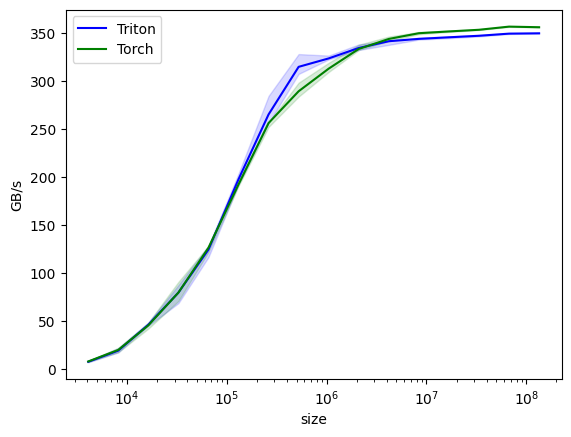

relu-performance-forward:
           size      Triton       Torch
0        4096.0    7.194380    7.547911
1        8192.0   18.846625   19.566879
2       16384.0   45.850746   45.176470
3       32768.0   79.277419   79.277419
4       65536.0  124.121216  126.030769
5      131072.0  197.397587  192.000000
6      262144.0  264.970349  255.999991
7      524288.0  314.572807  289.129413
8     1048576.0  323.368435  312.696613
9     2097152.0  334.225246  333.233892
10    4194304.0  341.296314  343.645205
11    8388608.0  343.720286  349.622453
12   16777216.0  345.380748  351.478001
13   33554432.0  346.966457  353.209501
14   67108864.0  349.185835  356.496821
15  134217728.0  349.525348  355.859147


In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='relu-performance-forward',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.relu(x), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_relu(x), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(print_data=True, show_plots=True)

# Day 4

In [ ]:
@triton.jit
def _softmax_fused_kernel(
    x_ptr,
    y_ptr,
    x_stride,
    y_stride,
    num_cols: tl.constexpr,
    BLOCK_SIZE: tl.constexpr
):
  row_idx = tl.program_id(axis=0)
  # The stride represents how much we need to increase the pointer to advance 1 row
  input_row_ptr = x_ptr + row_idx * x_stride
  # Since BLOCK_SIZE is next power of 2, each row can fit in single block
  col_offs = tl.arange(0, BLOCK_SIZE)
  input_row_ptrs = input_row_ptr + col_offs

  mask = col_offs < num_cols
  row = tl.load(input_row_ptrs, mask=mask, other=-float('inf'))
  row_minus_max_for_num_stability = row - tl.max(row, axis=0)

  numerator = tl.exp(row_minus_max_for_num_stability)
  denominator = tl.sum(numerator, axis=0)
  softmax_output = numerator / denominator

  output_row_ptr = y_ptr + row_idx * y_stride
  output_row_ptrs = output_row_ptr + col_offs
  tl.store(output_row_ptrs, softmax_output, mask=mask)

In [ ]:
def softmax(x: torch.Tensor):
  num_rows, num_cols = x.shape
  # Round up to the next power of 2 in case if num_cols is not power of 2
  BLOCK_SIZE = triton.next_power_of_2(num_cols)

  # Autotune is gonna replace this
  num_wraps = 4
  if BLOCK_SIZE >= 2048:
    num_wraps = 8
  if BLOCK_SIZE >= 4096:
    num_wraps = 16

  output = torch.empty_like(x)
  assert x.device == torch.device("cuda:0") and output.device == torch.device("cuda:0"), f"Tensors have wrong device expected cuda, but got x: {x.device} and output: {output.device}"

  _softmax_fused_kernel[(num_rows,)](
    x_ptr      = x,
    y_ptr      = output,
    x_stride   = x.stride(0),
    y_stride   = output.stride(0),
    num_cols   = num_cols,
    num_warps  = num_wraps,
    BLOCK_SIZE = BLOCK_SIZE
  )

  return output

In [ ]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device="cuda")
output_torch = torch.softmax(x, axis=-1)
output_triton = softmax(x)
print(f"Torch: {output_torch}")
print(f"Triton: {output_triton}")
assert torch.allclose(output_triton, output_torch), f"Results are not close: {(output_triton, output_torch)}"

Torch: tensor([[3.2747e-04, 5.3954e-04, 5.8687e-05,  ..., 5.5490e-04, 2.0330e-04,
         9.4091e-04],
        [8.6914e-04, 1.1075e-03, 1.0202e-04,  ..., 1.1470e-04, 5.5436e-04,
         8.6046e-04],
        [1.4101e-03, 1.0511e-03, 1.7031e-03,  ..., 1.2272e-03, 7.9059e-04,
         3.2380e-04],
        ...,
        [1.0722e-04, 3.6355e-04, 4.1703e-04,  ..., 3.5171e-04, 3.4261e-03,
         1.1834e-03],
        [6.7911e-04, 8.1645e-04, 6.9066e-04,  ..., 1.4361e-04, 9.6083e-04,
         2.5547e-03],
        [5.7850e-04, 9.4147e-04, 1.1231e-04,  ..., 3.4419e-03, 3.8817e-03,
         1.3192e-03]], device='cuda:0')
Triton: tensor([[3.2747e-04, 5.3954e-04, 5.8687e-05,  ..., 5.5490e-04, 2.0330e-04,
         9.4091e-04],
        [8.6914e-04, 1.1075e-03, 1.0202e-04,  ..., 1.1470e-04, 5.5436e-04,
         8.6046e-04],
        [1.4101e-03, 1.0511e-03, 1.7031e-03,  ..., 1.2272e-03, 7.9059e-04,
         3.2380e-04],
        ...,
        [1.0722e-04, 3.6355e-04, 4.1703e-04,  ..., 3.5171e-04, 3.426

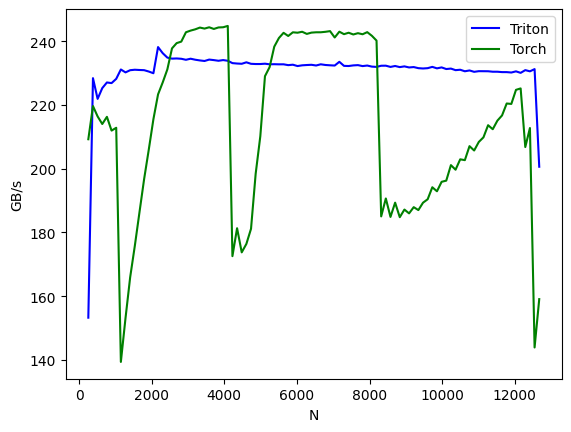

softmax-performance:
          N      Triton       Torch
0     256.0  153.237023  209.222673
1     384.0  228.386528  219.632361
2     512.0  221.890455  216.378650
3     640.0  225.263076  214.003942
4     768.0  227.034749  216.253443
5     896.0  226.837398  211.932117
6    1024.0  228.170799  212.822989
7    1152.0  231.111346  139.358873
8    1280.0  230.198907  153.111934
9    1408.0  230.884869  165.910269
10   1536.0  231.029510  175.746261
11   1664.0  230.951145  186.271992
12   1792.0  230.895557  196.692010
13   1920.0  230.468188  205.930961
14   2048.0  229.930225  215.501260
15   2176.0  238.140874  223.298870
16   2304.0  236.230949  227.041581
17   2432.0  234.837653  231.137529
18   2560.0  234.514737  237.729533
19   2688.0  234.567824  239.378219
20   2816.0  234.467894  239.859505
21   2944.0  234.151612  242.792167
22   3072.0  234.489577  243.308474
23   3200.0  234.174235  243.710208
24   3328.0  233.949174  244.258804
25   3456.0  233.774444  243.943149
26   35

In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device="cuda", dtype=torch.float32)
    stream = getattr(torch, "cuda").Stream()
    getattr(torch, "cuda").set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)

# Day 5

In [21]:
def get_cuda_autotune_config():
  return [
      triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
      triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                    num_warps=2),
      triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                    num_warps=2),
      # Good config for fp8 inputs.
      triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3,
                    num_warps=8),
      triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3,
                    num_warps=8),
      triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                    num_warps=4)
  ]

In [22]:
@triton.autotune(
    configs = get_cuda_autotune_config(),
    key     = ['M', 'N', 'K'],
)
@triton.jit
def _matmul_krnl(
    a_ptr,
    b_ptr,
    c_ptr,
    # Matrix dim
    M,
    N,
    K,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_am,
    stride_ak,
    stride_bk,
    stride_bn,
    stride_cm,
    stride_cn,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr,
):
  # Map program ids `pid` to the block of C it should compute.
  # This is done in a grouped ordering to promote L2 data reuse.
  pid = tl.program_id(axis=0)
  # Number of program ids along the M axis
  num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
  # Number of program ids along the N axis
  num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
  # Number of programs in group
  num_pid_in_group = GROUP_SIZE_M * num_pid_n
  # Id of the group this program is in
  group_id = pid // num_pid_in_group
  # Row-id of the first program in the group
  first_pid_m = group_id * GROUP_SIZE_M
  # If `num_pid_m` isn't divisible by `GROUP_SIZE_M`, the last group is smaller
  group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
  # *Within groups*, programs are ordered in a column-major order
  # Row-id of the program in the *launch grid*
  pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
  # Col-id of the program in the *launch grid*
  pid_n = (pid % num_pid_in_group) // group_size_m


  # Create pointers for the first blocks of A and B.
  # We will advance this pointer as we move in the K direction
  # and accumulate
  # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
  # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
  offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
  offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
  offs_k = tl.arange(0, BLOCK_SIZE_K)
  a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
  b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

  # Iterate to compute a block of the C matrix.
  # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
  # of fp32 values for higher accuracy.
  # `accumulator` will be converted back to fp16 after the loop.
  accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
  for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
    a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
    b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
    accumulator = tl.dot(a, b, accumulator)
    # Advance the ptrs to the next K block.
    a_ptrs += BLOCK_SIZE_K * stride_ak
    b_ptrs += BLOCK_SIZE_K * stride_bk
  c = accumulator.to(tl.float16)

  offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
  offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
  c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
  c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
  tl.store(c_ptrs, c, mask=c_mask)

In [23]:
def matmul(a: torch.Tensor, b: torch.Tensor):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    _matmul_krnl[grid](
        a_ptr     = a,
        b_ptr     = b,
        c_ptr     = c,
        M         = M,
        N         = N,
        K         = K,
        stride_am = a.stride(0),
        stride_ak = a.stride(1),
        stride_bk = b.stride(0),
        stride_bn = b.stride(1),
        stride_cm = c.stride(0),
        stride_cn = c.stride(1),
    )
    return c

In [24]:
torch.manual_seed(0)
a = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
b = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
triton_output = matmul(a, b)
torch_output = torch.matmul(a, b)
print(f"triton_output_with_fp16_inputs={triton_output}")
print(f"torch_output_with_fp16_inputs={torch_output}")
rtol = 1e-2
if torch.allclose(triton_output, torch_output, atol=1e-2, rtol=rtol):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

TORCH_HAS_FP8 = hasattr(torch, "float8_e5m2")
if TORCH_HAS_FP8:
    torch.manual_seed(0)
    a = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
    b = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
    a = a.to(torch.float8_e5m2)
    b = b.T
    b = b.to(torch.float8_e5m2)
    triton_output = matmul(a, b)
    torch_output = torch.matmul(a.to(torch.float16), b.to(torch.float16))
    print(f"triton_output_with_fp8_inputs={triton_output}")
    print(f"torch_output_with_fp8_inputs={torch_output}")
    if torch.allclose(triton_output, torch_output, atol=0.125, rtol=0):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")

triton_output_with_fp16_inputs=tensor([[ -0.6089,   5.5000,  -7.8633,  ...,  10.3594,  -2.4434,  -6.9180],
        [  7.0000,  16.2656,  26.4688,  ...,  11.8594,   4.5625,  18.3750],
        [  3.6777, -15.3125,  -2.0820,  ..., -41.7500,  26.8906, -12.5547],
        ...,
        [  0.7246,  75.0625, -26.1562,  ...,  26.6875,  -0.7197, -48.0000],
        [  6.6484,  -0.7490, -39.2500,  ..., -38.7812, -15.4609, -48.9688],
        [ 27.7812,  29.4062,  22.3281,  ...,  14.4922,   5.2344,  23.4844]],
       device='cuda:0', dtype=torch.float16)
torch_output_with_fp16_inputs=tensor([[ -0.6089,   5.5000,  -7.8633,  ...,  10.3594,  -2.4434,  -6.9180],
        [  7.0000,  16.2656,  26.4688,  ...,  11.8594,   4.5625,  18.3750],
        [  3.6777, -15.3125,  -2.0820,  ..., -41.7500,  26.8906, -12.5547],
        ...,
        [  0.7246,  75.0625, -26.1562,  ...,  26.6875,  -0.7197, -48.0000],
        [  6.6484,  -0.7490, -39.2500,  ..., -38.7812, -15.4609, -48.9688],
        [ 27.7812,  29.4062,  2

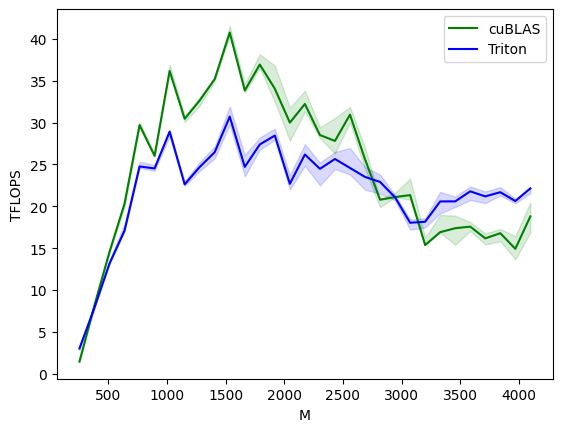

matmul-performance-fp16:
         M       N       K     cuBLAS     Triton
0    256.0   256.0   256.0   1.449310   3.021833
1    384.0   384.0   384.0   8.182529   7.899428
2    512.0   512.0   512.0  14.563555  13.168929
3    640.0   640.0   640.0  20.302355  17.093375
4    768.0   768.0   768.0  29.692242  24.758682
5    896.0   896.0   896.0  26.017185  24.520151
6   1024.0  1024.0  1024.0  36.157792  28.913772
7   1152.0  1152.0  1152.0  30.449806  22.621091
8   1280.0  1280.0  1280.0  32.633388  24.693294
9   1408.0  1408.0  1408.0  35.190486  26.460917
10  1536.0  1536.0  1536.0  40.747038  30.708753
11  1664.0  1664.0  1664.0  33.830498  24.705317
12  1792.0  1792.0  1792.0  36.926240  27.388178
13  1920.0  1920.0  1920.0  34.036163  28.444444
14  2048.0  2048.0  2048.0  29.991114  22.687243
15  2176.0  2176.0  2176.0  32.217166  26.185620
16  2304.0  2304.0  2304.0  28.505815  24.475279
17  2432.0  2432.0  2432.0  27.806836  25.646431
18  2560.0  2560.0  2560.0  30.944224  24.57

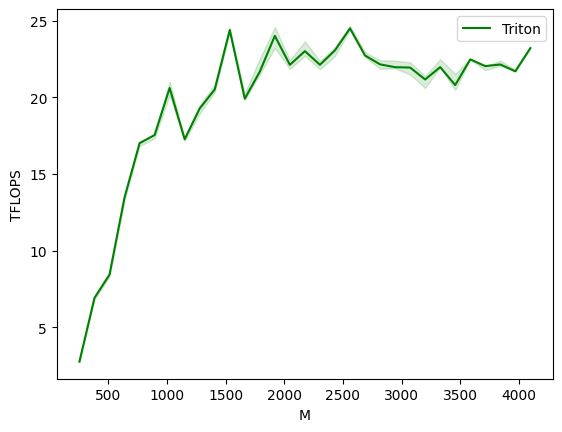

matmul-performance-fp8:
         M       N       K     Triton
0    256.0   256.0   256.0   2.748561
1    384.0   384.0   384.0   6.912000
2    512.0   512.0   512.0   8.430762
3    640.0   640.0   640.0  13.473685
4    768.0   768.0   768.0  17.014154
5    896.0   896.0   896.0  17.547891
6   1024.0  1024.0  1024.0  20.617162
7   1152.0  1152.0  1152.0  17.270941
8   1280.0  1280.0  1280.0  19.278128
9   1408.0  1408.0  1408.0  20.521919
10  1536.0  1536.0  1536.0  24.406511
11  1664.0  1664.0  1664.0  19.920115
12  1792.0  1792.0  1792.0  21.688572
13  1920.0  1920.0  1920.0  24.022809
14  2048.0  2048.0  2048.0  22.131705
15  2176.0  2176.0  2176.0  23.024768
16  2304.0  2304.0  2304.0  22.135053
17  2432.0  2432.0  2432.0  23.077312
18  2560.0  2560.0  2560.0  24.511467
19  2688.0  2688.0  2688.0  22.740362
20  2816.0  2816.0  2816.0  22.161690
21  2944.0  2944.0  2944.0  21.978101
22  3072.0  3072.0  3072.0  21.954384
23  3200.0  3200.0  3200.0  21.175948
24  3328.0  3328.0  3328.0

In [ ]:
ref_lib = 'cuBLAS'

configs = []
for fp8_inputs in [False, True]:
    if fp8_inputs and (not TORCH_HAS_FP8):
        continue
    configs.append(
        triton.testing.Benchmark(
            x_names=["M", "N", "K"],  # Argument names to use as an x-axis for the plot
            x_vals=[128 * i for i in range(2, 33)],  # Different possible values for `x_name`
            line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
            # Possible values for `line_arg`
            # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
            line_vals=["triton"] if fp8_inputs else [ref_lib.lower(), "triton"],  # Label name for the lines
            line_names=["Triton"] if fp8_inputs else [ref_lib, "Triton"],  # Line styles
            styles=[("green", "-"), ("blue", "-")],
            ylabel="TFLOPS",  # Label name for the y-axis
            plot_name="matmul-performance-" +
            ("fp16" if not fp8_inputs else "fp8"),  # Name for the plot, used also as a file name for saving the plot.
            args={"fp8_inputs": fp8_inputs},
        ))


@triton.testing.perf_report(configs)
def benchmark(M, N, K, provider, fp8_inputs):
    a = torch.randn((M, K), device=DEVICE, dtype=torch.float16)
    b = torch.randn((K, N), device=DEVICE, dtype=torch.float16)
    if TORCH_HAS_FP8 and fp8_inputs:
        a = a.to(torch.float8_e5m2)
        b = b.T
        b = b.to(torch.float8_e5m2)
    quantiles = [0.5, 0.2, 0.8]
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=True, print_data=True)

# Day 6

In [ ]:
@triton.jit
def _seed_dropout_krnl(
    a_ptr,
    out_ptr,
    num_el,
    p,
    seed,
    BLOCK_SIZE: tl.constexpr
):
  pid = tl.program_id(axis=0)

  block_start = pid * BLOCK_SIZE
  offs = block_start + tl.arange(0, BLOCK_SIZE)
  mask = offs < num_el
  a_ptrs = a_ptr + offs
  a = tl.load(a_ptrs, mask=mask)

  random = tl.rand(seed, offs)
  x_keep = random > p
  output = tl.where(x_keep, a / (1 - p), 0.0)
  out_ptrs = out_ptr + offs

  tl.store(out_ptrs, output, mask=mask)

In [ ]:
def seed_dropout(a: torch.Tensor, p: float, seed: int):
  output = torch.empty_like(a)
  assert a.is_contiguous()
  num_el = a.numel()
  grid = lambda meta: (triton.cdiv(num_el, meta['BLOCK_SIZE']), )
  _seed_dropout_krnl[grid](
    a_ptr      = a,
    out_ptr    = output,
    num_el     = num_el,
    p          = p,
    seed       = seed,
    BLOCK_SIZE = 1024
  )

  return output

In [ ]:
import tabulate

a = torch.randn(size=(10, ), device=DEVICE)
# Compare this to the baseline - dropout mask is never instantiated!
output = seed_dropout(a, p=0.5, seed=123)
output2 = seed_dropout(a, p=0.2, seed=123)
output3 = seed_dropout(a, p=0.5, seed=512)

print(
    tabulate.tabulate([
        ["input"]               + a.tolist(),
        ["output (seed = 123)"] + output.tolist(),
        ["output (seed = 123)"] + output2.tolist(),
        ["output (seed = 512)"] + output3.tolist(),
    ]))

-------------------  --------  --------  --------  --------  --------  --------  --------  --------  --------  ----------
input                0.108609  0.159025  -1.06662  -1.70072  0.304993  -1.38563  0.424757  -1.11785  0.307858  0.00876422
output (seed = 123)  0         0.31805    0         0        0         -2.77126  0          0        0.615717  0.0175284
output (seed = 123)  0         0.198781  -1.33327  -2.1259   0.381241  -1.73204  0         -1.39731  0.384823  0.0109553
output (seed = 512)  0         0         -2.13324  -3.40144  0         -2.77126  0.849515   0        0         0
-------------------  --------  --------  --------  --------  --------  --------  --------  --------  --------  ----------


# Day 7

In [ ]:
@triton.jit
def _seed_dropout_krnl(
    x_ptr,
    y_ptr,
    x_stride,
    y_stride,
    num_cols,
    p,
    seed,
    BLOCK_SIZE: tl.constexpr
):
  pid = tl.program_id(0)

  row_input_block_start = x_ptr + (pid * x_stride)
  col_offs = tl.arange(0, BLOCK_SIZE)
  mask = col_offs < num_cols
  row_input_ptrs = row_input_block_start + col_offs

  row = tl.load(row_input_ptrs, mask=mask)
  # Part pid * BLOCK_SIZE + col_offs is used for better randomization, otherwise random pattern will be repeatable
  random = tl.rand(seed, pid * BLOCK_SIZE + col_offs)
  x_keep = random > p

  output = tl.where(x_keep, row / (1 - p), 0.0)
  row_output_ptr = y_ptr + (pid * y_stride)
  row_output_ptrs = row_output_ptr + col_offs

  tl.store(row_output_ptrs, output, mask=mask)

In [ ]:
def seed_dropout(a: torch.Tensor, p: float, seed: int):
  rows, cols = a.shape

  output = torch.empty_like(a)

  assert a.is_contiguous()

  grid = (rows, )

  _seed_dropout_krnl[grid](
    x_ptr      = a,
    y_ptr      = output,
    x_stride   = a.stride(0),
    y_stride   = output.stride(0),
    num_cols   = cols,
    p          = p,
    seed       = seed,
    BLOCK_SIZE = 1024
  )

  return output

In [ ]:
import tabulate

a = torch.randn(size=(3, 4), device=DEVICE)
# Compare this to the baseline - dropout mask is never instantiated!
output = seed_dropout(a, p=0.5, seed=123)
output2 = seed_dropout(a, p=0.6, seed=123)
output3 = seed_dropout(a, p=0.5, seed=512)

print(
    tabulate.tabulate([
        ["input"]               + a.tolist(),
        ["output (seed = 123)"] + output.tolist(),
        ["output (seed = 123)"] + output2.tolist(),
        ["output (seed = 512)"] + output3.tolist(),
    ]))

-------------------  -------------------------------------------------------------------------------------  ----------------------------------------------------------------------------------  -----------------------------------------------------------------------------------
input                [-0.027588587254285812, 0.021280569955706596, 0.333994597196579, -1.0321085453033447]  [-1.245145559310913, 0.4508974552154541, -0.38042837381362915, 2.1656196117401123]  [-1.3127740621566772, -1.536977767944336, -0.6176518797874451, 0.15861906111240387]
output (seed = 123)  [0.0, 0.04256113991141319, 0.0, 0.0]                                                   [0.0, 0.9017949104309082, -0.7608567476272583, 4.331239223480225]                   [0.0, -3.073955535888672, -1.2353037595748901, 0.0]
output (seed = 123)  [0.0, 0.053201425820589066, 0.0, 0.0]                                                  [0.0, 1.1272436380386353, -0.9510709047317505, 5.41404914855957]                    [0.0, -3.842

# Day 8

In [ ]:
import torchvision.transforms.functional as tvf
from torchvision import io

import matplotlib.pyplot as plt
from typing import Tuple

In [ ]:
path_to_image = "/content/girl.jpeg"
img = io.read_image(path_to_image)
img = tvf.resize(img, 150, antialias=True)

In [ ]:
def show_img(x, figsize=(4,3), **kwargs):
  plt.figure(figsize=figsize)
  plt.axis('off')
  if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
  plt.imshow(x.cpu(), **kwargs)

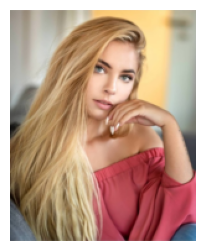

In [ ]:
show_img(img)

In [ ]:
@triton.jit
def _grayscale_krnl(
    x_ptr,
    y_ptr,
    h,
    w,
    BLOCK_SIZE_H: tl.constexpr,
    BLOCK_SIZE_W: tl.constexpr,
):
  pid_h = tl.program_id(axis=0)
  pid_w = tl.program_id(axis=1)

  offs_h = pid_h * BLOCK_SIZE_H + tl.arange(0, BLOCK_SIZE_H) # Shape: (BLOCK_SIZE_H,)
  offs_w = pid_w * BLOCK_SIZE_W + tl.arange(0, BLOCK_SIZE_W) # Shape: (BLOCK_SIZE_W,)
  offs = w * offs_h[:, None] + offs_w[None, :] # (BLOCK_SIZE_H, 1) X (1, BLOCK_SIZE_W) -> (BLOCK_SIZE_H, BLOCK_SIZE_W)

  mask_h = offs_h < h # Shape: (BLOCK_SIZE_H,)
  mask_w = offs_w < w # Shape: (BLOCK_SIZE_W,)
  mask = mask_h[:, None] & mask_w[None, :] # (BLOCK_SIZE_H, 1) & (1, BLOCK_SIZE_W) -> (BLOCK_SIZE_H, BLOCK_SIZE_W)

  r = tl.load(x_ptr + 0 * h * w + offs, mask=mask)
  g = tl.load(x_ptr + 1 * h * w + offs, mask=mask)
  b = tl.load(x_ptr + 2 * h * w + offs, mask=mask)

  output = 0.2989 * r + 0.5870 * g + 0.1140 * b
  out_ptrs = y_ptr + offs

  tl.store(out_ptrs, output, mask=mask)


In [ ]:
def grayscale(x: torch.Tensor, block_sizes: Tuple[int, int]):
  c, h, w = x.shape

  output = torch.empty((h, w), dtype=x.dtype, device=x.device)

  grid = lambda meta: (triton.cdiv(h, meta['BLOCK_SIZE_H']), triton.cdiv(w, meta['BLOCK_SIZE_W']))

  _grayscale_krnl[grid](
    x_ptr        = x,
    y_ptr        = output,
    h            = h,
    w            = w,
    BLOCK_SIZE_H = block_sizes[0],
    BLOCK_SIZE_W = block_sizes[1],
  )

  return output.view(h, w)

In [ ]:
grey_img = grayscale(img.to('cuda'), block_sizes=(32, 32)).to('cpu')

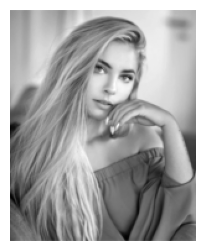

In [ ]:
show_img(grey_img, cmap='gray')

# Day 9

In [ ]:
@triton.jit
def _transpose_2D_krnl(
    x_ptr,
    y_ptr,
    stride_xh,
    stride_xw,
    stride_yh,
    stride_yw,
    h,
    w,
    BLOCK_SIZE: tl.constexpr
):
  pid = tl.program_id(axis=0)

  row = pid // w
  col = pid % w

  # Check if we're within matrix bounds
  if row < h and col < w:
    x_offs = row * stride_xh + col * stride_xw
    y_offs = col * stride_yh + row * stride_yw # switch for transpose col with row

    val = tl.load(x_ptr + x_offs)

    tl.store(y_ptr + y_offs, val)

In [ ]:
def transpose(x: torch.Tensor):
  height, width = x.shape

  output = torch.empty((width, height), dtype=x.dtype, device=x.device)

  if not x.is_contiguous:
    x = x.contiguous()

  grid = (height * width, )

  _transpose_2D_krnl[grid](
    x_ptr      = x,
    y_ptr      = output,
    stride_xh  = x.stride(0),
    stride_xw  = x.stride(1),
    stride_yh  = output.stride(0),
    stride_yw  = output.stride(1),
    h          = height,
    w          = width,
    BLOCK_SIZE = 1024
  )

  return output

In [ ]:
rows = 10
cols = 4

x = torch.rand((rows, cols), device=DEVICE)

out_triton = transpose(x = x)
out_torch = x.transpose(0, 1)

print(f"Input:  {x}")
print(f"Triton: {out_triton}")
print(f"Torch:  {out_torch}")

if torch.allclose(out_triton, out_torch, atol=1e-2, rtol=0):
  print("✅ Triton and Torch match")
else:
  print("❌ Triton and Torch differ")

Input:  tensor([[0.6079, 0.6494, 0.3004, 0.6745],
        [0.3309, 0.0534, 0.2387, 0.7001],
        [0.0726, 0.0930, 0.3742, 0.6410],
        [0.1389, 0.3734, 0.2374, 0.1754],
        [0.7447, 0.3656, 0.9834, 0.7690],
        [0.9079, 0.6556, 0.1994, 0.7089],
        [0.4704, 0.0313, 0.3436, 0.2980],
        [0.5977, 0.1974, 0.5670, 0.7965],
        [0.7768, 0.4247, 0.6196, 0.3345],
        [0.9416, 0.2210, 0.5763, 0.2432]], device='cuda:0')
Triton: tensor([[0.6079, 0.3309, 0.0726, 0.1389, 0.7447, 0.9079, 0.4704, 0.5977, 0.7768,
         0.9416],
        [0.6494, 0.0534, 0.0930, 0.3734, 0.3656, 0.6556, 0.0313, 0.1974, 0.4247,
         0.2210],
        [0.3004, 0.2387, 0.3742, 0.2374, 0.9834, 0.1994, 0.3436, 0.5670, 0.6196,
         0.5763],
        [0.6745, 0.7001, 0.6410, 0.1754, 0.7690, 0.7089, 0.2980, 0.7965, 0.3345,
         0.2432]], device='cuda:0')
Torch:  tensor([[0.6079, 0.3309, 0.0726, 0.1389, 0.7447, 0.9079, 0.4704, 0.5977, 0.7768,
         0.9416],
        [0.6494, 0.0534, 

# Day 10

In [ ]:
def get_cuda_autotune_config():
  return [
      triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64}, num_stages=3,
                      num_warps=8),
      triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32}, num_stages=5,
                    num_warps=2),
      triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32}, num_stages=5,
                    num_warps=2),
      # Good config for fp8 inputs.
      triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128}, num_stages=3,
                    num_warps=8),
      triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128}, num_stages=3,
                    num_warps=8),
      triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 64}, num_stages=4,
                    num_warps=4)
  ]

In [ ]:
# Gemm -> C = a * (A @ B) + b * C
# C -> [M, N]
# A -> [M, K]
# B -> [K, N]
# C = A @ B = [M, K] @ [K, N] = [M, N]
# Pass: A, B, C, M, N, K, (A, B, C) strides[row, col]
# Blocks for (M, N, K) will be autotuned using autotune from triton example

@triton.autotune(
    configs = get_cuda_autotune_config(),
    key     = ['M', 'N', 'K'],
)
@triton.jit
def _gemm_krnl(
    A,
    B,
    C,
    M,
    N,
    K,
    strides_am,
    strides_ak,
    strides_bk,
    strides_bn,
    strides_cm,
    strides_cn,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
):
  pid_m = tl.program_id(axis=0)
  pid_n = tl.program_id(axis=1)

  offs_m = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
  offs_n = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
  offs_k = tl.arange(0, BLOCK_SIZE_K)

  a_ptrs = A + offs_m[:, None] * strides_am + offs_k[None, :] * strides_ak
  b_ptrs = B + offs_k[:, None] * strides_bk + offs_n[None, :] * strides_bn
  c_ptrs = C + offs_m[:, None] * strides_cm + offs_n[None, :] * strides_cn

  acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)

  for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
    a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
    b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)

    acc = tl.dot(a, b, acc)

    a_ptrs += BLOCK_SIZE_K * strides_ak
    b_ptrs += BLOCK_SIZE_K * strides_bk

  c = acc.to(tl.float16)

  mask_c = (offs_m[:, None] < M) & (offs_n[None, :] < N)

  tl.store(c_ptrs, c, mask=mask_c)

In [ ]:
def gemm(A: torch.Tensor, B: torch.Tensor):
  assert A.shape[1] == B.shape[0], "Incompatible dimensions"
  assert A.is_contiguous(), "Matrix A must be contiguous"

  M, K = A.shape
  K, N = B.shape

  C = torch.empty((M, N), dtype = torch.float16, device = A.device)

  grid = lambda meta: (triton.cdiv(M, meta['BLOCK_SIZE_M']), triton.cdiv(N, meta['BLOCK_SIZE_N']))

  _gemm_krnl[grid](
    A            = A,
    B            = B,
    C            = C,
    M            = M,
    N            = N,
    K            = K,
    strides_am   = A.stride(0),
    strides_ak   = A.stride(1),
    strides_bk   = B.stride(0),
    strides_bn   = B.stride(1),
    strides_cm   = C.stride(0),
    strides_cn   = C.stride(1),
  )
  return C

In [ ]:
torch.manual_seed(0)
a = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
b = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
triton_output = gemm(a, b)
torch_output = torch.matmul(a, b)
print(f"triton_output_with_fp16_inputs={triton_output}")
print(f"torch_output_with_fp16_inputs={torch_output}")
rtol = 1e-2
if torch.allclose(triton_output, torch_output, atol=1e-2, rtol=rtol):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

TORCH_HAS_FP8 = hasattr(torch, "float8_e5m2")
if TORCH_HAS_FP8:
    torch.manual_seed(0)
    a = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
    b = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
    a = a.to(torch.float8_e5m2)
    b = b.T
    b = b.to(torch.float8_e5m2)
    triton_output = gemm(a, b)
    torch_output = torch.matmul(a.to(torch.float16), b.to(torch.float16))
    print(f"triton_output_with_fp8_inputs={triton_output}")
    print(f"torch_output_with_fp8_inputs={torch_output}")
    if torch.allclose(triton_output, torch_output, atol=0.125, rtol=0):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")

triton_output_with_fp16_inputs=tensor([[ -0.6089,   5.5000,  -7.8633,  ...,  10.3594,  -2.4434,  -6.9180],
        [  7.0000,  16.2656,  26.4688,  ...,  11.8594,   4.5625,  18.3750],
        [  3.6777, -15.3125,  -2.0820,  ..., -41.7500,  26.8906, -12.5547],
        ...,
        [  0.7246,  75.0625, -26.1562,  ...,  26.6875,  -0.7197, -48.0000],
        [  6.6484,  -0.7490, -39.2500,  ..., -38.7812, -15.4609, -48.9688],
        [ 27.7812,  29.4062,  22.3281,  ...,  14.4922,   5.2344,  23.4844]],
       device='cuda:0', dtype=torch.float16)
torch_output_with_fp16_inputs=tensor([[ -0.6089,   5.5000,  -7.8633,  ...,  10.3594,  -2.4434,  -6.9180],
        [  7.0000,  16.2656,  26.4688,  ...,  11.8594,   4.5625,  18.3750],
        [  3.6777, -15.3125,  -2.0820,  ..., -41.7500,  26.8906, -12.5547],
        ...,
        [  0.7246,  75.0625, -26.1562,  ...,  26.6875,  -0.7197, -48.0000],
        [  6.6484,  -0.7490, -39.2500,  ..., -38.7812, -15.4609, -48.9688],
        [ 27.7812,  29.4062,  2

# Day 11 - Neuron or MLP

In [25]:
def get_cuda_autotune_config():
  return [
      triton.Config({'BLOCK_SIZE_BS': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_M': 64, 'GROUP_SIZE_BS': 8}, num_stages=3,
                      num_warps=8),
      triton.Config({'BLOCK_SIZE_BS': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_M': 32, 'GROUP_SIZE_BS': 8}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_BS': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_M': 32, 'GROUP_SIZE_BS': 8}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_BS': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_M': 32, 'GROUP_SIZE_BS': 8}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_BS': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_M': 32, 'GROUP_SIZE_BS': 8}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_BS': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_M': 32, 'GROUP_SIZE_BS': 8}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_BS': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_M': 32, 'GROUP_SIZE_BS': 8}, num_stages=5,
                    num_warps=2),
      triton.Config({'BLOCK_SIZE_BS': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_M': 32, 'GROUP_SIZE_BS': 8}, num_stages=5,
                    num_warps=2),
      # Good config for fp8 inputs.
      triton.Config({'BLOCK_SIZE_BS': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_M': 128, 'GROUP_SIZE_BS': 8}, num_stages=3,
                    num_warps=8),
      triton.Config({'BLOCK_SIZE_BS': 256, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_M': 128, 'GROUP_SIZE_BS': 8}, num_stages=3,
                    num_warps=8),
      triton.Config({'BLOCK_SIZE_BS': 256, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_M': 128, 'GROUP_SIZE_BS': 8}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_BS': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_M': 128, 'GROUP_SIZE_BS': 8}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_BS': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_M': 128, 'GROUP_SIZE_BS': 8}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_BS': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_M': 64, 'GROUP_SIZE_BS': 8}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_BS': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_M': 64, 'GROUP_SIZE_BS': 8}, num_stages=4,
                    num_warps=4),
      triton.Config({'BLOCK_SIZE_BS': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_M': 64, 'GROUP_SIZE_BS': 8}, num_stages=4,
                    num_warps=4)
  ]

In [26]:
# y = W*x + b
# in_features = m, out_features = n
# W = (n, m)
# x = (batch_size, m)
# b = (n,)
# y = x @ W.T + b = (batch_size, m) @ (m, n) + (n,) = (batch_size, n) + (n,) = (batch_size, n)
# W, x, y, batch_size, n, m, (W, x) strides(row, col), (Block_size_bs, Block_size_n, Block_size_m, group_size_m) autotune

@triton.autotune(
    configs = get_cuda_autotune_config(),
    key     = ['BS', 'N', 'M'],
)
@triton.jit
def _linear_layer_fwd(
    W             ,
    X             ,
    y             ,
    BS            ,
    N             ,
    M             ,
    strides_wn    ,
    strides_wm    ,
    strides_xbs   ,
    strides_xm    ,
    strides_ybs   ,
    strides_yn    ,
    BLOCK_SIZE_BS : tl.constexpr,
    BLOCK_SIZE_N  : tl.constexpr,
    BLOCK_SIZE_M  : tl.constexpr,
    GROUP_SIZE_BS : tl.constexpr
):
  pid = tl.program_id(axis=0)
  num_pid_bs = tl.cdiv(BS, BLOCK_SIZE_BS)
  num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
  num_pid_in_group = GROUP_SIZE_BS * num_pid_n
  group_id = pid // num_pid_in_group
  first_pid_bs = group_id * GROUP_SIZE_BS
  group_size_bs = min(num_pid_bs - first_pid_bs, GROUP_SIZE_BS)
  pid_bs = first_pid_bs + ((pid % num_pid_in_group) % group_size_bs)
  pid_n = (pid % num_pid_in_group) // group_size_bs

  # Remove modulo to rely on grid bounds
  offs_bs = pid_bs * BLOCK_SIZE_BS + tl.arange(0, BLOCK_SIZE_BS)
  offs_n = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
  offs_m = tl.arange(0, BLOCK_SIZE_M)

  # Pointers
  # W -- [BLOCK_SIZE_N, BLOCK_SIZE_M]
  # X -- [BLOCK_SIZE_BS, BLOCK_SIZE_M]
  # b -- [BLOCK_SIZE_N]
  # y -- [BLOCK_SIZE_BS, BLOCK_SIZE_N]
  w_ptrs = W + (offs_n[:, None] * strides_wn + offs_m[None, :] * strides_wm)
  x_ptrs = X + (offs_bs[:, None] * strides_xbs + offs_m[None, :] * strides_xm)

  acc = tl.zeros((BLOCK_SIZE_BS, BLOCK_SIZE_N), dtype=tl.float32)
  for m in range(0, tl.cdiv(M, BLOCK_SIZE_M)):
    m_start = m * BLOCK_SIZE_M
    m_bound = tl.minimum(m_start + BLOCK_SIZE_M, M)
    m_size = m_bound - m_start
    mask_m = tl.arange(0, BLOCK_SIZE_M) < m_size
    # offs_m[None, :] -- [1, BLOCK_SIZE_M]
    # offs_m[:, None] -- [BLOCK_SIZE_M, 1]
    mask_w = (offs_n[:, None] < N) & (mask_m[None, :])
    mask_x = (offs_bs[:, None] < BS) & (mask_m[None, :])

    w = tl.load(w_ptrs, mask=mask_w, other=0.0)
    x = tl.load(x_ptrs, mask=mask_x, other=0.0)
    acc = tl.dot(x, tl.trans(w), acc)

    w_ptrs += BLOCK_SIZE_M * strides_wm
    x_ptrs += BLOCK_SIZE_M * strides_xm

  acc = acc.to(tl.float16)

  # Output
  offs_ybs = pid_bs * BLOCK_SIZE_BS + tl.arange(0, BLOCK_SIZE_BS)
  offs_yn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
  mask_y = (offs_ybs[:, None] < BS) & (offs_yn[None, :] < N)
  y_ptrs = y + (offs_ybs[:, None] * strides_ybs + offs_yn[None, :] * strides_yn)
  tl.store(y_ptrs, acc, mask=mask_y)

In [27]:
def linear(inputs, weight):
  # checks constraints
  assert inputs.shape[1] == weight.shape[1], "incompatible dimensions"
  assert inputs.is_contiguous(), "matrix A must be contiguous"
  assert weight.is_contiguous(), "matrix B must be contiguous"

  BS, M = inputs.shape
  N, M = weight.shape
  # allocates output

  y = torch.empty((BS, N), device=inputs.device, dtype=torch.float16)
  # 1D launch kernel where each block gets its own program.
  grid = lambda META: (
      triton.cdiv(BS, META["BLOCK_SIZE_BS"]) * triton.cdiv(N, META["BLOCK_SIZE_N"]),
  )
  _linear_layer_fwd[grid](
      W             = weight,
      X             = inputs,
      y             = y,
      BS            = BS,
      N             = N,
      M             = M,
      strides_wn    = weight.stride(0),
      strides_wm    = weight.stride(1),
      strides_xbs   = inputs.stride(0),
      strides_xm    = inputs.stride(1),
      strides_ybs   = y.stride(0),
      strides_yn    = y.stride(1),
  )
  return y

In [30]:
torch.manual_seed(0)
BS = 32
M = 64
N = 32

inputs = torch.randn((BS, M), device="cuda", dtype=torch.float16)
weight = torch.randn((N, M), device="cuda", dtype=torch.float16)

triton_output = linear(inputs, weight)
torch_output = torch.nn.functional.linear(inputs, weight)

print(f"triton_output={triton_output}")
print(f"torch_output={torch_output}")
if torch.allclose(triton_output, torch_output):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

triton_output=tensor([[ -1.5469,  11.9688,   4.5586,  ...,  -5.6445, -10.2812,  -3.5762],
        [  7.5938,  12.8047,  -4.3711,  ...,  -0.6309,  -8.4453,   1.9600],
        [  2.6016,  -1.0811,   4.2422,  ...,  -3.1660,   2.3066,  -1.7812],
        ...,
        [ 11.7031,   2.1211,  15.6641,  ...,  -4.1211,  -0.1814,  -1.4131],
        [-11.3203,   7.7891,  -6.4570,  ...,  -5.3828,  -5.9727,  -7.7734],
        [  3.6348,   4.8438,  -8.5938,  ...,   6.1133,  -9.3125,  11.8984]],
       device='cuda:0', dtype=torch.float16)
torch_output=tensor([[ -1.5469,  11.9688,   4.5586,  ...,  -5.6445, -10.2812,  -3.5762],
        [  7.5938,  12.8047,  -4.3711,  ...,  -0.6309,  -8.4453,   1.9600],
        [  2.6016,  -1.0811,   4.2422,  ...,  -3.1660,   2.3066,  -1.7812],
        ...,
        [ 11.7031,   2.1211,  15.6641,  ...,  -4.1211,  -0.1814,  -1.4131],
        [-11.3203,   7.7891,  -6.4570,  ...,  -5.3828,  -5.9727,  -7.7734],
        [  3.6348,   4.8438,  -8.5938,  ...,   6.1133,  -9.3125, 